# Text Mining Project Work (Team 3)

**Text Classification and Sentiment Analysis**

- Godowicz Pietro
- Hofmockel Oliver
- Malavita Daniela
- Mioli Riccardo

**Bologna Business School** - Alma Mater Studiorum Università di Bologna

## Setup

The following cell contains some necessary imports

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import gzip
import json
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import os
from urllib.request import urlretrieve
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
!pip install keras-tuner
import keras_tuner
from sklearn.model_selection import GridSearchCV

Run the following to download the necessary files

In [ ]:
def download(file, url):
    if not os.path.exists(file):
        urlretrieve(url, file)

In [ ]:
download("Automotive_5.json.gz", "https://www.dropbox.com/s/vfpxgpoii7lpy4x/Automotive_5.json.gz?dl=1")

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Exercises

1) We provide in the `Automotive_5.json.gz` file a dataset composed by several reviews posted on Amazon.com about Automotive products. That file is a gzip compressed one so you have to open it using a gzip decompression library.
Each review is labeled with a score between 1 and 5 stars (represented by the ```overall``` feature).

The text of each review is represented by the ```reviewText``` feature which is going to be our input data along with the ```overall``` one.

Load the first 300000 reviews in the dataset putting it in a new Pandas dataframe. The data is stored as JSON file so you will have to use a Python package to load json data into some variable.

In [ ]:
# Loading and decompression of gzip, and requesting only the first 300,000 reivews in the dataset
df = pd.read_json("Automotive_5.json.gz", compression="gzip", lines=True)
df = df.iloc[:300000,:]

2) Print the dataset rows number and visualize the first 5 rows.

In [ ]:
df.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,NaN,NaN
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,NaN,NaN
2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,NaN,NaN
3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,NaN,NaN
4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,NaN,NaN


3) Undersample the data by `overall` feature in order to obtain a class-balanced dataset.



The dataset now has 38630 rows and 12 columns.


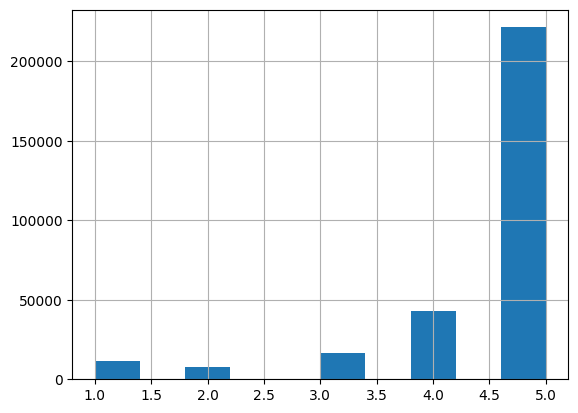

In [ ]:
# Visualization before undersampling, then using undersampling to balance target
df.overall.hist()
X, Y = RandomUnderSampler().fit_resample(df, df["overall"])
print("The dataset now has %i rows and %i columns." % X.shape)

4) Cast the `reviewText` column to unicode string



In [ ]:
# Casting 'reviewText' to string
X['reviewText'] = X['reviewText'].astype(str)

**5)** Select from data only the features named ```reviewText``` and ```overall``` putting them in a dataframe





In [ ]:
# Taking only the features 'reviewText' and 'overall' from original dataset
X=X[['reviewText','overall']]
print("The dataset now has %i rows and %i columns." % X.shape)

The dataset now has 38630 rows and 2 columns.


**6)** Verify the distribution of the number of stars

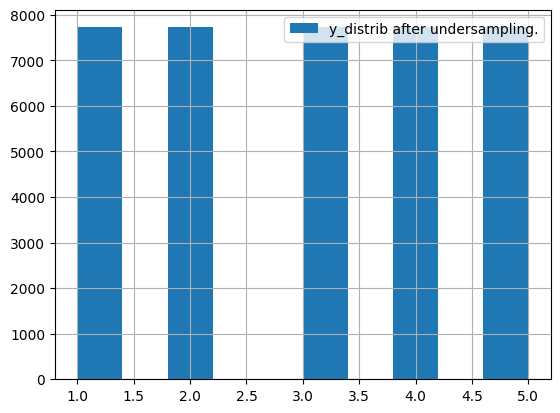

In [ ]:
# Verification of distribution after undersampling
X.overall.hist()
plt.legend(["y_distrib after undersampling."])

**7)** Remove from the dataframe the reviews rated with 3 stars.

In [ ]:
#Removing reviews with 3 stars
X = X[X['overall'] != 3]

**8)** Add a `label` column to the DataFrame whose value is `"pos"` for reviews with 4 or 5 stars and `"neg"` for reviews with 1 or 2 stars.

In [ ]:
# Addition of label column
X["label"] = X.overall.map({1:"neg", 2:"neg", 4:"pos",5:"pos"})
X.head()

<ipython-input-37-81b973820834>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["label"] = X.overall.map({1:"neg", 2:"neg", 4:"pos",5:"pos"})


,reviewText,overall,label
0,"After 6-9 months of installation on the hitch,...",1,neg
1,What a waste of money. This level is way-off. ...,1,neg
2,Cover ripped on backside of tanks during first...,1,neg
3,I've got a couple and have used them and when ...,1,neg
4,Not a great fit for a 2006 Honda Pilot. Oil le...,1,neg


**9)** Split the dataset randomly into a training set with 65% of data and a test set with the remaining 35%, stratifying the split by the `label` variable

In [ ]:
#Split dataset into train and test set
X_train, x_test, Y_train, y_test = train_test_split(X["reviewText"],X["label"], train_size=0.65, stratify=X["label"], random_state=42)

**10)** Create a tf.idf vector space model from training reviews excluding words appearing in less than 7 documents and using only unigrams. Then, extract the document-term matrix for them.

In [ ]:
#Creating tf.idf vector space without nan and extracting doc-term matrix
X_train.fillna("", inplace=True)
x_test.fillna("",inplace=True)
vectorizer = TfidfVectorizer(min_df=7, ngram_range=(1,1)).fit(X_train)
X_train = vectorizer.transform(X_train)
x_test = vectorizer.transform(x_test)

**11)** Train a Multinomial Naive Bayes classifier on the training reviews, using the representation created above

In [ ]:
# Training the Multinomial Naive Bayes classifier with X_train and Y_train
modelmnb = MultinomialNB()
modelmnb.fit(X_train, Y_train)

MultinomialNB()

**12)** Verify the accuracy of the classifier on the test set

In [ ]:
# Using score to return the mean accuracy
accuracy = modelmnb.score(x_test, y_test)

print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 0.84%


In [ ]:
# We decided to tune the alpha parameter available to multinomial naive bayes
# We specify the alphas grid values to be tested in the hyperparameters optimization
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}

# we use grid search to find the best alpha
grid_search = GridSearchCV(modelmnb, param_grid, cv=5, scoring='accuracy').fit(X_train, Y_train)

# print best param and keep best estimator
print("Best param for alpha is %s " % grid_search.best_params_)
modelmnb = grid_search.best_estimator_

y_pred_mnb = modelmnb.predict(x_test)

Best param for alpha is {'alpha': 1.5} 


13) Train a Deep Learning model using the document-term representation built in point 10.

In [ ]:
# Changing the label format for the deep learning model
Y_train = pd.DataFrame({"pos": Y_train == "pos", "neg": Y_train == "neg"}).astype(int)
y_test = pd.DataFrame({"pos": y_test == "pos", "neg": y_test == "neg"}).astype(int)
display(Y_train.head())
display(y_test.head())

,pos,neg
10543,0,1
24065,1,0
30846,1,0
37625,1,0
6607,0,1


,pos,neg
25956,1,0
4552,0,1
13100,0,1
2731,0,1
14067,0,1


In [ ]:
# Defining functions for neural network creation

input_size = X_train.shape[1]
output_size = Y_train.shape[1]

#This function will be used to return models with different configurations
def model_factory(input_size:int, output_size:int, units:int=128, h_layers:int=1,
               activation:str="relu", dropout:float=.0):
    # We define the network topology using the functional api
    inputs = layers.Input(shape=(input_size,))
    x = inputs
    for i in range(h_layers):
        #Define how many other hidden layers we want
        x = layers.Dense(units, activation = activation)(x)
        if dropout:
            # Add dropout after each layer, if enabled
            x = layers.Dropout(rate=dropout)(x)
    outputs = layers.Dense(output_size, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="three_net")
    return model

#The model generator will be used as input for a hyperparameter generator (keras-tuner),
#this will be used during the model tuning, and used to generate configurations of hyperparameters used for model instantation
def model_generator(hp):
  #The tuner will return a number of units for each layer, a number of hidden
  #layers, and activation function and a dropout float
    units = hp.Int("units",min_value=32, max_value =512, step=32)
    h_layers = hp.Int("h_layers",min_value=1, max_value =12, step=2)
    activation=hp.Choice("activation", ["relu", "tanh", "swish"])
    dropout = hp.Float("dropout", min_value=0.01, max_value=0.25, step=0.01)
    # The parameters are passed to the model factory and a compiled keras model will be returned
    model = model_factory(input_size, output_size, units, h_layers, activation, dropout)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model

#Utility function to convert a scipy sparse matrix to tensorflow sparse tensor
def csr_matrix_to_sparse_tensor(X:csr_matrix):
    indexes = np.column_stack(X.nonzero())
    data = X.data
    shape = X.shape
    return tf.sparse.reorder(tf.SparseTensor(indexes,data, shape))

Model: "three_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5440)]            0         
                                                                 
 dense_4 (Dense)             (None, 128)               696448    
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 696,706
Trainable params: 696,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
67/67 [==============================] - 4s 33ms/step - loss: 0.6056 - categorical_accuracy: 0.7582
Epoch 2/5
67/67 [==============================] - 2s 35ms/step - loss: 0.3921 - categorical_accuracy: 0.8637
Epoch 3/5
67/67 [==============================] - 3s 39ms/step - loss: 0.2952 - categorical_ac

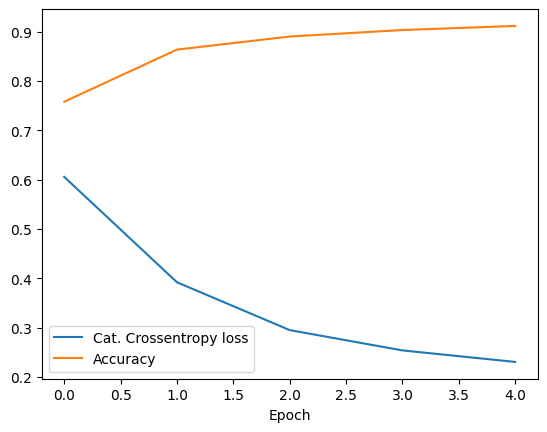

In [ ]:
#Creates a base model with a single hidden layer with 128 units
model = model_factory(input_size, output_size)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=[tf.keras.metrics.CategoricalAccuracy()])

fit_hist = model.fit(x=csr_matrix_to_sparse_tensor(X_train),y= np.asarray(Y_train), batch_size=300, epochs=5)

plt.plot(fit_hist.history["loss"])
plt.plot(fit_hist.history["categorical_accuracy"])
plt.legend(["Cat. Crossentropy loss", "Accuracy"])
plt.xlabel("Epoch")
plt.show()

14) Evaluate the model calculating the accuracy on test data. Try to maximize the model accuracy by tuning the neural network.

In [ ]:
# Evaluation of accuracy on test data
test_scores = model.evaluate(csr_matrix_to_sparse_tensor(x_test), np.asarray(y_test), verbose=2)
print("The accuracy on the test set of the base model is: %f" % test_scores[1])

339/339 - 3s - loss: 0.3126 - categorical_accuracy: 0.8624 - 3s/epoch - 8ms/step
The accuracy on the test set of the base model is: 0.862439


In [ ]:
# For the tuning we create a validation set, to do it we create a dataset to use the take and skip functions to split the dataset.
dataset = tf.data.Dataset.from_tensor_slices((csr_matrix_to_sparse_tensor(X_train), np.asarray(Y_train)))
VAL_SIZE = 0.2
n_rows = dataset.cardinality().numpy()

train_set = dataset.take(int(n_rows*(1-VAL_SIZE)))
train_set = train_set.batch(300)
val_set = dataset.skip(int(n_rows*(1-VAL_SIZE)))
val_set = val_set.batch(300)

# We  invoke the model tuner to try various configurations for the neural network architecture
tuner = keras_tuner.RandomSearch(hypermodel=model_generator, objective="val_categorical_accuracy", max_trials=10,
                                 overwrite= True, seed=42)
# We use early stopping in the search to avoid overfitting.
tuner.search(train_set, epochs=30, validation_data=val_set,
             callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy",
                                                            patience=3, restore_best_weights = True)])

# Finally we evaluate over the testing set the best model found
model = tuner.get_best_models(1)[0]
model.summary()

Trial 10 Complete [00h 00m 31s]
val_categorical_accuracy: 0.8606271743774414

Best val_categorical_accuracy So Far: 0.8606271743774414
Total elapsed time: 00h 04m 48s
Model: "three_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5440)]            0         
                                                                 
 dense (Dense)               (None, 448)               2437568   
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 898       
                                                                 
Total params: 2,438,466
Trainable params: 2,438,466
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluation after tuning to maximize accuracy
test_scores = model.evaluate(csr_matrix_to_sparse_tensor(x_test), np.asarray(y_test), verbose=2)
print("The accuracy on the test set of the tuned model is: %f" % test_scores[1])

339/339 - 1s - loss: 0.3169 - categorical_accuracy: 0.8637 - 1s/epoch - 4ms/step
The accuracy on the test set of the tuned model is: 0.863733


15) Get the predictions of this latter model and the Multinomial Naive Bayes model (trained in point 11) ones.

Then compare them using the McNemar test and setting a confidence level = 95%, i.e. p-value must be > 0.05 for models to be significantly similar.

To obtain the p-value, use the provided `mcnemar_pval` function providing the arrays with the labels predicted by the two models and the true ones.

```
mcnemar_pval(model1_predictions, model2_predictions, y_test)
```
Note: McNemar test cannot be applied to compare two models on different test set data.

Hint: you will need to adapt the type of the two model predictions to integer arrays in order to be compared.


In [ ]:
def mcnemar_pval(p1, p2, y_test):
    model1_errors = p1 != y_test
    model2_errors = p2 != y_test

    # define contingency table
    mc_table = pd.crosstab(model1_errors, model2_errors)

    print(mc_table)

    # calculate mcnemar test
    mc_result = mcnemar(mc_table)
    return mc_result.pvalue

In [ ]:
#The classifiers make classifications using slightly different labels, we need to change few things
y_test_f = y_test.iloc[:,0].reset_index(drop=True) # The first column is for positive reviews and has a 1 when the review is positive
y_pred_mnb_f = pd.Series(y_pred_mnb).map({'neg': 0, 'pos': 1})# We need to translate the positive reviews in 1 and negatives in 0
# This retrieves the max probability predicted for each class. Since the neuron 0 is for positive reviews and neuron 1 is for negative reviews,
# the np.argmax will give us 0 for positive reviews (i.e. the max probability is in neuron 0) and 1 for negetive reviews.
# This encoding is inverted with respect of the others, so we need to map 0 as 1 and 1 as 0
y_pred_dnn_f = pd.Series(np.argmax(model.predict(csr_matrix_to_sparse_tensor(x_test)), axis=1)).map({0:1, 1:0})

pval = mcnemar_pval(y_pred_mnb_f, y_pred_dnn_f, y_test_f)

confidence_level = 0.95
alpha = 1-confidence_level

print(pval)
if pval > alpha:
    print("The difference in the errors is not statistically significant (accept H0) - The two models are equivalent")
else:
    print("The difference in the errors is statistically significant (reject H0) - The two models are not equivalent")

339/339 [==============================] - 1s 3ms/step
col_0  False  True 
row_0              
False   8736    420
True     607   1054
The difference in the errors is statistically significant (reject H0) - The two models are not equivalent
5.899450506366029e-09
